# Visualization of Stock Trading

In [1]:
# import libraries
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
import datetime
import pandas_datareader.data as web

import matplotlib.pyplot as plt

import logging
import coloredlogs

from train import *
from evaluate import show_eval_result

Using TensorFlow backend.


[[0.5        0.5        0.5        0.5        0.00247262 0.99330715]]
(1, 6)


In [2]:
# in case of error on notebook: Istll vega_datasets
#conda install -c conda-forge altair vega_datasets notebook vega
#see also https://altair-viz.github.io/getting_started/installation.html
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Set relevant parameters

In [3]:
#train_stock = 'data/GOOGL.csv'
#val_stock = 'data/AAPL_2018.csv'
window_size = 10
batch_size = 16
ep_count = 7 # for debugging, otherwise 15-50
model_name = 'model_Stefan'
pretrained = False
debug = False

## Load Datasets into pandas DataFrame

In [4]:
# read csv into dataframe
#df = pd.read_csv(val_stock)

# Setting Start and Enddate for Validation
start_train= datetime.datetime(2012, 1, 1)
end_train = datetime.datetime(2018, 1, 1)
start_val = end_train
end_val = datetime.datetime.now()


# Load Training and Validation data
# 1st. dataset as trading target
# 2nd. dataset as additional input feature

df_train = web.DataReader('AAPL','yahoo',
                               start=start_train, #start_train
                               end=end_train)  #end_train

df2_train = web.DataReader('GOLD','yahoo',
                               start=start_train, #start_train
                               end=end_train) #end_train


df_val = web.DataReader('AAPL','yahoo',
                               start=start_val, #start_train
                               end=end_val) #end_val
df2_val = web.DataReader('GOLD','yahoo',
                               start=start_val, #start_val
                               end=end_val)  #end_val

df = df_val # will be used to show actions and for plotting

#rename feature column names
df = df.rename(columns={'Adj Close': 'actual'})


# filter out the desired features



# Generate list objects
df_train_list = list(df_train['Adj Close'])
df_val_list = list(df_val['Adj Close'])
df2_train_list = list(df2_train['Adj Close'])
df2_val_list = list(df2_val['Adj Close'])


# Deleting obsolete dataframes
del df_train
del df_val
del df2_train
del df2_val

df.head()

# Open tast: Clean datasets (Adj Close, data that is not necessary)

,High,Low,Open,Close,Volume,actual
Date,,,,,,
2018-01-02,172.300003,169.259995,170.160004,172.259995,25555900.0,167.701889
2018-01-03,174.550003,171.960007,172.529999,172.229996,29517900.0,167.672668
2018-01-04,173.470001,172.080002,172.539993,173.029999,22434600.0,168.451508
2018-01-05,175.369995,173.050003,173.440002,175.000000,23660000.0,170.369385
2018-01-08,175.610001,173.929993,174.350006,174.350006,20567800.0,169.736588


## Visualization of actions taken by Trading Bot

In [9]:
def visualize(df, history):
    # add history to dataframe
    position = [history[0][0]] + [x[0] for x in history]
    actions = ['HOLD'] + [x[1] for x in history]
    df['position'] = position
    df['action'] = actions
    
    #alt.Chart(df.reset_index()).mark_line().encode(x='index')
    
    # specify y-axis scale for stock prices
    scale = alt.Scale(domain=(min(min(df['actual']), min(df['position'])) - 50, max(max(df['actual']), max(df['position'])) + 50), clamp=True)
    
    # plot a line chart for stock positions
    actual = alt.Chart(df.reset_index()).mark_line(
        color='green',
        opacity=0.5
    ).encode(
        x='Date:T', #'date:T'
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Price'), scale=scale)
    ).interactive(
        bind_y=False
    )
    
    # plot the BUY and SELL actions as points
    points = alt.Chart(df.reset_index()).transform_filter(
        alt.datum.action != 'HOLD'
    ).mark_point(
        filled=True
    ).encode(
        x=alt.X('Date:T', axis=alt.Axis(title='Date')),
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Price'), scale=scale),
        color='action'
        #color=alt.Color('action', scale=alt.Scale(range=['blue', 'red']))
    ).interactive(bind_y=False)

    # merge the two charts
    chart = alt.layer(actual, points, title="your stock").properties(height=300, width=1000)
    
    return chart

## Training the model

In [28]:
coloredlogs.install(level='DEBUG')
switch_k_backend_device() #switches to CPU (acc. to author faster than GPU)


train_data = df_train_list  
val_data = df_val_list 
train_data2 = df2_train_list #None
val_data2 = df2_val_list # None



if train_data2 is not None:
    agent = Agent(window_size*2, pretrained=False, model_name=model_name)
else:
    agent = Agent(window_size, pretrained=False, model_name=model_name)

initial_offset = val_data[1] - val_data[0]

reslist_t =[] # Train Reward for plotting
reslist_v = [] # Val Reward for plotting
for i in range(1, ep_count + 1): 
    train_result = train_model(agent, i, train_data, train_data2, ep_count=ep_count,
                                batch_size=batch_size, window_size=window_size)
    val_result, _ = evaluate_model(agent, val_data, val_data2, window_size, debug)
    show_train_result(train_result, val_result, initial_offset)
    reslist_t.append(train_result[2]) # append reward of training
    reslist_v.append(val_result)
    

I1001 21:33:47.827925 17820 train.py:156] switching to TensorFlow for CPU
2019-10-01 21:33:47 PC-Stefan root[12684] DEBUG switching to TensorFlow for CPU
Episode 1/5: 100%|██████████| 1508/1508 [00:15<00:00, 95.19it/s] 
I1001 21:34:03.888806 17820 train.py:147] Episode 1/5 - Train Position: +$151.60  Val Position: +$6.57  Train Loss: 0.0528  (~15.8535 secs)
2019-10-01 21:34:03 PC-Stefan root[12684] INFO Episode 1/5 - Train Position: +$151.60  Val Position: +$6.57  Train Loss: 0.0528  (~15.8535 secs)
Episode 2/5: 100%|██████████| 1508/1508 [00:15<00:00, 97.14it/s] 
I1001 21:34:19.544884 17820 train.py:147] Episode 2/5 - Train Position: +$49.59  Val Position: -$1.52  Train Loss: 0.0632  (~15.5279 secs)
2019-10-01 21:34:19 PC-Stefan root[12684] INFO Episode 2/5 - Train Position: +$49.59  Val Position: -$1.52  Train Loss: 0.0632  (~15.5279 secs)
Episode 3/5: 100%|██████████| 1508/1508 [00:15<00:00, 96.66it/s] 
I1001 21:34:35.284504 17820 train.py:147] Episode 3/5 - Train Position: +$25.84 

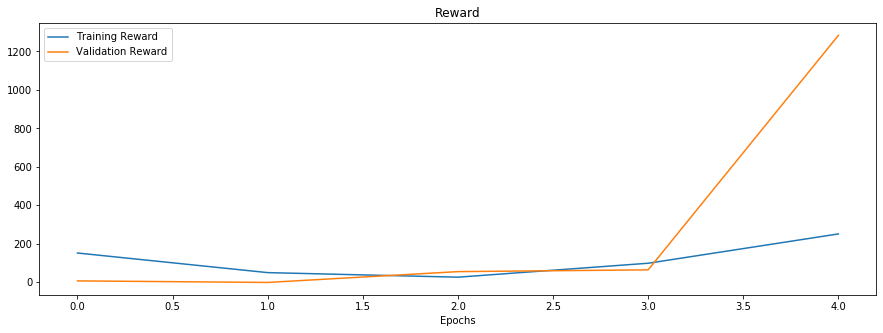

In [29]:
# Plotting Result
plt.figure(figsize = (15,5))
plt.plot(reslist_t, label = "Training Reward");
plt.plot(reslist_v, label = "Validation Reward");
plt.title("Reward")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Plotting the evaluation actions

I1001 21:36:10.119172 17820 evaluate.py:111] model_Stefan: +$1283.79

2019-10-01 21:36:10 PC-Stefan root[12684] INFO model_Stefan: +$1283.79



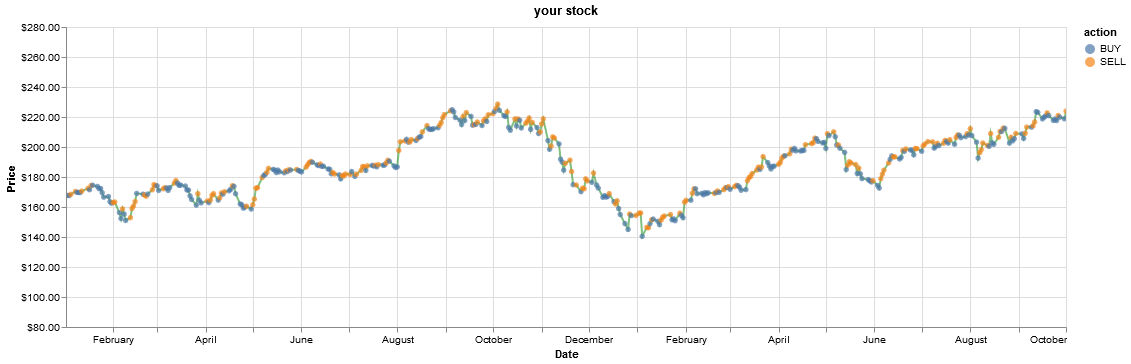

In [30]:
val_result, history = evaluate_model(agent, val_data,val_data2, window_size, debug)
show_eval_result(model_name, val_result, initial_offset)
chart = visualize(df, history)
chart

In [13]:
df.tail()

,High,Low,Open,Close,Volume,actual,position,action
Date,,,,,,,,
2019-09-25,221.500000,217.139999,218.550003,221.029999,21903400.0,221.029999,217.679993,HOLD
2019-09-26,220.940002,218.830002,220.000000,219.889999,18833500.0,219.889999,221.029999,HOLD
2019-09-27,220.960007,217.279999,220.539993,218.820007,25352000.0,218.820007,219.889999,HOLD
2019-09-30,224.580002,220.789993,220.899994,223.970001,25977400.0,223.970001,218.820007,HOLD
2019-10-01,228.199997,224.699997,225.070007,224.863998,23523363.0,224.863998,223.970001,HOLD


## Testing the Model

I1001 21:40:30.512553 17820 connectionpool.py:813] Starting new HTTPS connection (1): finance.yahoo.com:443
2019-10-01 21:40:30 PC-Stefan urllib3.connectionpool[12684] DEBUG Starting new HTTPS connection (1): finance.yahoo.com:443
I1001 21:40:31.168847 17820 connectionpool.py:393] https://finance.yahoo.com:443 "GET /quote/ADBE/history?period1=1451617200&period2=1569981599&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
2019-10-01 21:40:31 PC-Stefan urllib3.connectionpool[12684] DEBUG https://finance.yahoo.com:443 "GET /quote/ADBE/history?period1=1451617200&period2=1569981599&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
I1001 21:40:31.749879 17820 connectionpool.py:393] https://finance.yahoo.com:443 "GET /quote/AAPL/history?period1=1451617200&period2=1569981599&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
2019-10-01 21:40:31 PC-Stefan urllib3.connectionpool[12684] DEBUG https://finance.yahoo.com:443 "GET /quote/AAPL/history?period1=1451617200&perio

<Figure size 432x288 with 0 Axes>

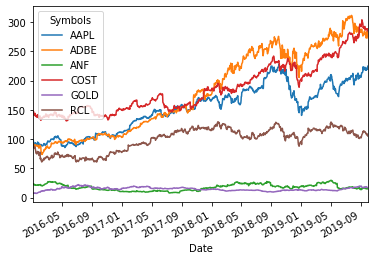

In [41]:
# Loading Test Data
# Setting Start and Enddate for Validation


start_test = datetime.datetime(2016, 1, 1)
end_test = datetime.datetime.now()

# Load Test Data

# Load several stocks
df_test = web.DataReader(['ADBE', 'AAPL', 'RCL', 'COST', 'ANF', 'GOLD'],'yahoo',
                               start=start_test, 
                               end=end_test)['Adj Close']
df2_test = web.DataReader('GOLD','yahoo',
                               start=start_test, end=end_test)

# Convert df2_test to list
df2_test_list = list(df2_test['Adj Close'])

plt.figure();
df_test.plot();


In [47]:
#Load Model
model_name = 'model_Stefan_20'
# Init Model
window_size = 10


# Initialize Agent
if train_data2 is not None:
    agent = Agent(window_size*2, pretrained=True, model_name=model_name)
else:
    agent = Agent(window_size, pretrained=True, model_name=model_name)


# Loop over stocks
for column in df_test:
    print(column)
    #rename feature column name
    df_test_list = list(df_test[column])
    dft = df_test.rename(columns={column: 'actual'})
    
    val_result, history = evaluate_model(agent, df_test_list, df2_test_list, window_size, debug)
    show_eval_result(model_name, val_result, initial_offset)
    chart = visualize(dft, history)
    
    print("Earnings of Model: ", val_result)
    chart



AAPL


I1001 21:44:22.107350 17820 evaluate.py:111] model_Stefan_20: +$46.61

2019-10-01 21:44:22 PC-Stefan root[12684] INFO model_Stefan_20: +$46.61



Earnings of Model:  46.61161804199219
ADBE


I1001 21:44:22.529263 17820 evaluate.py:111] model_Stefan_20: +$99.28

2019-10-01 21:44:22 PC-Stefan root[12684] INFO model_Stefan_20: +$99.28



Earnings of Model:  99.27986145019531
ANF


I1001 21:44:22.919913 17820 evaluate.py:111] model_Stefan_20: +$2.93

2019-10-01 21:44:22 PC-Stefan root[12684] INFO model_Stefan_20: +$2.93



Earnings of Model:  2.928133010864258
COST


I1001 21:44:23.326192 17820 evaluate.py:111] model_Stefan_20: +$25.33

2019-10-01 21:44:23 PC-Stefan root[12684] INFO model_Stefan_20: +$25.33



Earnings of Model:  25.329849243164062
GOLD


I1001 21:44:23.716832 17820 evaluate.py:111] model_Stefan_20: +$0.34

2019-10-01 21:44:23 PC-Stefan root[12684] INFO model_Stefan_20: +$0.34



Earnings of Model:  0.34389305114746094
RCL


I1001 21:44:24.140408 17820 evaluate.py:111] model_Stefan_20: +$30.73

2019-10-01 21:44:24 PC-Stefan root[12684] INFO model_Stefan_20: +$30.73



Earnings of Model:  30.73487091064453
